## 0. Install packages and helper functions

In [2]:
# !pwd

/repos/u01/synapse/inhipy/notebooks


In [3]:
# !pip install --upgrade pip
# !pip install -e ../.

Obtaining file:///repos/u01/synapse/inhipy
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for inhipy (pyproject.toml) ... done
  Created wheel for inhipy: filename=inhipy-0.0.1-0.editable-py3-none-any.whl size=1861 sha256=96e0e202dd5da05615bfb2af647952b213f7e945d24c338bb594c04054c1f6e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-sv4iaq96/wheels/a3/5d/02/a729b3fd1a756346d04f01f8aa6d568d4e53ffa103678bcffe
Successfully built inhipy
  Attempting uninstall: inhipy
    Found existing installation: inhipy 0.0.1
    Uninstalling inhipy-0.0.1:
      Successfully uninstalled inhipy-0.0.1

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip


## 1. Import packages

In [1]:
# make sure the package autoreloads
%load_ext autoreload
%autoreload 2

In [12]:
from inhipy.utils.plotter import plot_slice_with_insert
import tifffile as tif

## 2. Prepare data

The data we will use is the manually annotated data for gad1b fish,
taken with **XXX** microscope and **YYY** parameters.

The annotated data is stored in the **/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b/** folder.
Each subfolder contains the data for one image, there are 6 folders : 2 time points for 3 fish.
In each image, only the left hemisphere is annotated! You will have to drop unsegmentes synapses!

Each subfolder has the following files:
- **image.tif** : the raw image
- **ROI_synaptic_only.csv** : the synapses coordinates (only candidates that were classified as synapses)
- **ROI.npz** : npz file, that has all the candidates coordinates among othr things.

### Look at the data

In [6]:
# load data and show example image
example_img = tif.imread('/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b/1-1VWT/Fish1_Nacre-like_47_LED_TP1-Done.ome.tiff')
example_img.shape

(211, 1024, 1024)

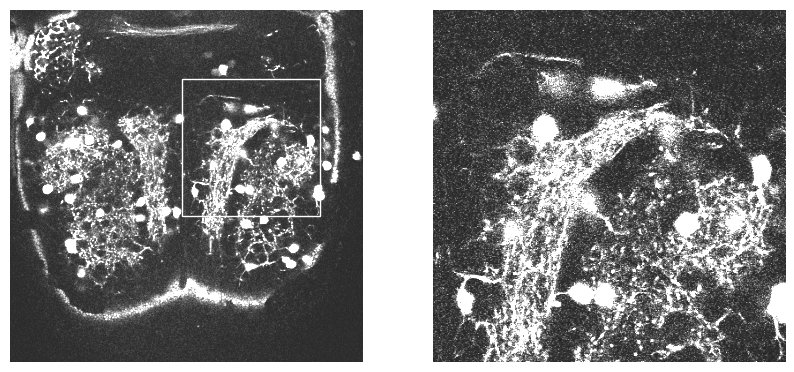

In [11]:
plot_slice_with_insert(example_img, vmin = 500, vmax = 4000)

### Prepare patches for training

We will
1. drop unsegmented area by removing the unnecessary centroids and cropping the images ( anything that is larger in x then 500 and in z then 90 will be removed, see drop_unsegmented and drop_unsegmented_image for more details)
2. then we will create the segemntation by drawing spheres around the synapses (see draw_balls for more details)
3. finally, we will split the cropped images into patches of size 32x32x32, and save them in the **/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b_patches_32/** folder.

**NOTE**: will save only such patches where sum of masked pixes is above the threshold. Default is 3 balls (see save_patches for more details)

In [25]:
from inhipy.segmentation.preprocess import (
    load_data,
    draw_balls,
    drop_unsegmented_image,
    patchify_and_save,
    plot_segmentation_example
)

In [20]:
data_dir = "/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b/"
patch_size = 32

for roi_id in ['1-1VWT','1-1VWW','1-1VX8','1-1VXC','1-1WH8','1-1WHA']:
    # get centroids labels and an image for a fish
    centroids, labels, img = load_data(data_dir, roi_id)

    # draw circles with the value = synapse number around synapses
    segmentation = draw_balls(img, centroids, labels)

    # get rid of the portion of the image tht is not segmented
    img = drop_unsegmented_image(img, centroids)
    segmentation = drop_unsegmented_image(segmentation, centroids)

    # split the images and labels into patches ( save as 16 bit labels)
    saved = patchify_and_save(segmentation,
                              patch_size=patch_size,
                              file_tag = roi_id,
                              save_folder= f"/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b_patches_32/{roi_id}/seg/")
    patchify_and_save(img,
                      patch_size=32,
                      file_tag = roi_id,
                      save_folder= f"/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b_patches_32/{roi_id}/img/", save = saved)

Segmented synapses from (53, 13, 13) to (90, 1010, 500)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
Segmented synapses from (53, 13, 13) to (90, 1010, 500)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
saved : (1, 31, 15)
Segmented synapses from (61, 13, 13) to 

Plot example segmentation:

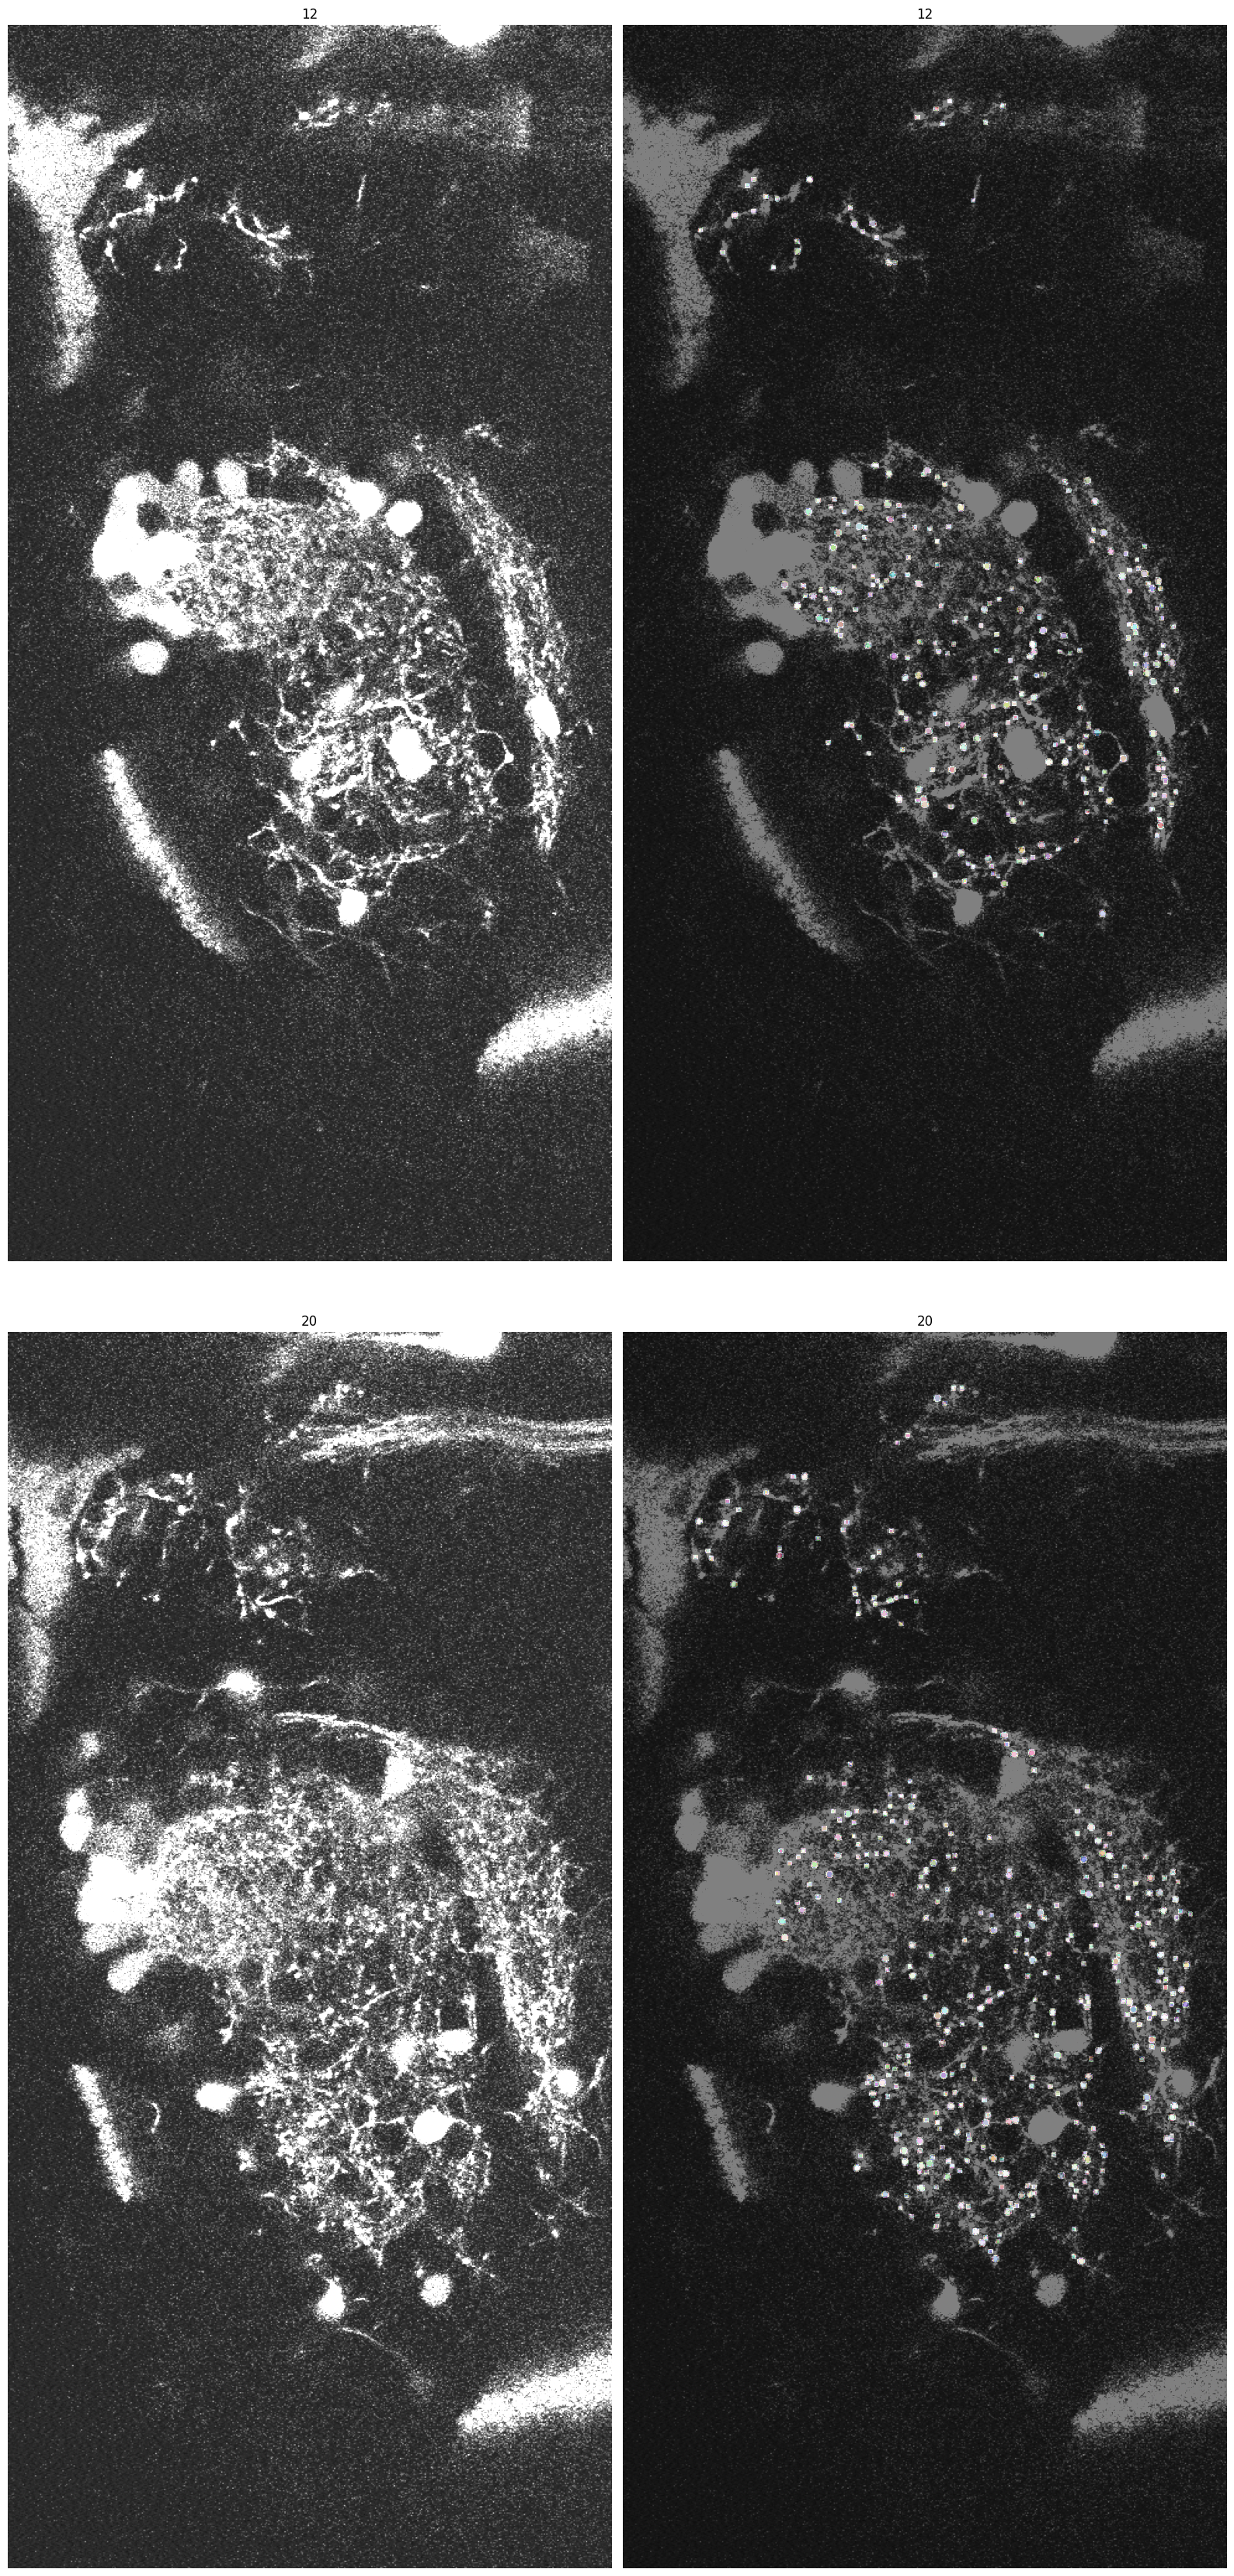

In [37]:
plot_segmentation_example(img, segmentation, vmin = 500, vmax = 4500)

## 3. Find the best parameters for shape fitting

### Load patches

In [61]:
from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist.matching import matching_dataset
from glob import glob
from pathlib import Path
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [54]:
patch_dir = "/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b_patches_32/"
# get the filenames in all the folders
X = sorted(glob(patch_dir + '*/img/*.tif'))
Y = sorted(glob(patch_dir + '*/seg/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

# print example file names
print(X[0], Y[0])

/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b_patches_32/1-1VWT/img/1-1VWT_img_shape_(41, 997, 487)_patch_shape_(1, 31, 15)_0_0_4.tif /repos/u01/synapse/data/synapse_detection/classified_manual/gad1b_patches_32/1-1VWT/seg/1-1VWT_img_shape_(41, 997, 487)_patch_shape_(1, 31, 15)_0_0_4.tif


In [56]:
# Load only a small subset
X, Y = X[:10], Y[:10]

X = list(map(tif.imread,X))
Y = list(map(tif.imread,Y))

extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.6666666666666667, 1.0, 1.0)


### Fitting ground-truth labels with star-convex polyhedra

In [59]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

n_rays = [8, 16, 32, 64, 96, 128]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 17.82it/s]


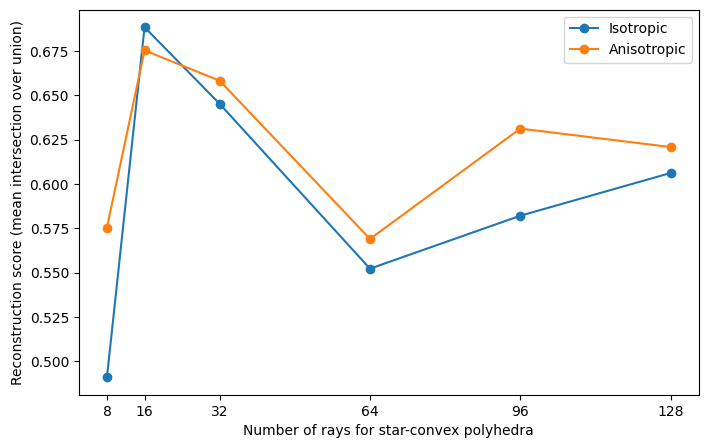

In [62]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.xticks(n_rays)
plt.legend()
None;

**Conclusion**: we will need **16 rays** for the star-convex polyhedra